In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def find_contours(dimensions, img) :
    # gray_img = cv2.bilateralFilter(img, 11, 17, 17)
    # edged_img = cv2.Canny(gray_img, 30, 200) 
 
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(cntrs))
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
          x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

          char_copy = np.zeros((44,24))
          # extracting each character using the enclosing rectangle's coordinates.
          char = img[intY:intY+intHeight, intX:intX+intWidth]
          char = cv2.resize(char, (20, 40))
          
          cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
          #plt.imshow(ii, cmap='gray')

          # Make result formatted for classification: invert colors
          char = cv2.subtract(255, char)

          # Resize the image to 24x44 with black border
          char_copy[2:42, 2:22] = char
          char_copy[0:2, :] = 0
          char_copy[:, 0:2] = 0
          char_copy[42:44, :] = 0
          char_copy[:, 22:24] = 0

          img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    #plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
def segment_characters(image) :

    # Preprocess cropped license plate image 
    img_lp = cv2.resize(image, (333, 75),interpolation=cv2.INTER_AREA)
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/7,
                       LP_WIDTH,
                       LP_HEIGHT/18,
                       3*LP_HEIGHT/3]
    #plt.imshow(img_binary_lp, cmap='gray')
    #plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    # print(dimensions)
    char_list = find_contours(dimensions,img_binary_lp)

    return char_list

In [ ]:
dbfile = open('/content/drive/MyDrive/Forensics/binaries/train_image', 'rb')     
x_train = pickle.load(dbfile)
dbfile.close()

dbfile = open('/content/drive/MyDrive/Forensics/binaries/train_label', 'rb')     
x_train_label = pickle.load(dbfile)
dbfile.close()

dbfile = open('/content/drive/MyDrive/Forensics/binaries/train_image1', 'rb')     
x_train1 = pickle.load(dbfile)
dbfile.close()

dbfile = open('/content/drive/MyDrive/Forensics/binaries/train_label1', 'rb')     
x_train1_label = pickle.load(dbfile)
dbfile.close()

In [ ]:
# x_train.extend(x_train1)
# x_train_label.extend(x_train1_label)

In [ ]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/drive/MyDrive/Forensics/license/license/data/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 326s 376ms/step - loss: 3.0729 - custom_f1score: 0.1516 - val_loss: 2.0387 - val_custom_f1score: 0.4137
Epoch 2/80
864/864 [==============================] - 77s 89ms/step - loss: 1.4343 - custom_f1score: 0.5694 - val_loss: 0.8308 - val_custom_f1score: 0.7307
Epoch 3/80
864/864 [==============================] - 75s 87ms/step - loss: 0.7373 - custom_f1score: 0.7708 - val_loss: 0.4048 - val_custom_f1score: 0.9033
Epoch 4/80
864/864 [==============================] - 78s 90ms/step - loss: 0.4732 - custom_f1score: 0.8438 - val_loss: 0.2789 - val_custom_f1score: 0.9048
Epoch 5/80
864/864 [==============================] - 77s 89ms/step - loss: 0.3401 - custom_f1score: 0.8924 - val_loss: 0.3070 - val_custom_f1score: 0.8929
Epoch 6/80
864/864 [==============================] - 76s 88ms/step - loss: 0.2652 - custom_f1score: 0.9236 - val_loss: 0.2772 - val_custom_f1score: 0.9211
Epoch 7/80
864/864 [==============================] - 75s 87ms

In [ ]:
model.save("/content/drive/MyDrive/Forensics/binaries/Model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Forensics/binaries/Model/assets


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Forensics/binaries/Model", custom_objects={'f1score':f1score,'custom_f1score':custom_f1score})

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [ ]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0] #predicting the class
        # print(y_)
        
        #character = dic[y_] #
        ind=np.where(y_==1)
        # print(ind[0])
        #if choice==1:
        #print(ind)
        if len(ind[0])!=0:
          #print('hi')
          output.append(characters[int(ind[0])]) #storing the result in a list
        
    plate_number = ''.join(output)
    #if plate_number=='HH12JC353Z':
    choice=1
    #print(plate_number)
    return plate_number

# print(show_results(char))

In [ ]:
dbfile = open('/content/drive/MyDrive/Forensics/binaries/real_world_image', 'rb')     
x_test = pickle.load(dbfile)
dbfile.close()

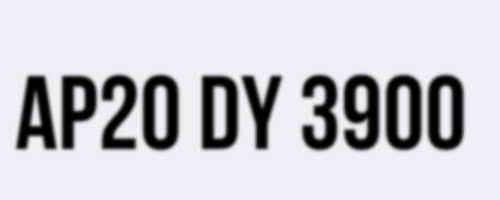

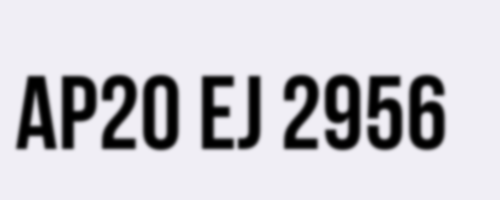

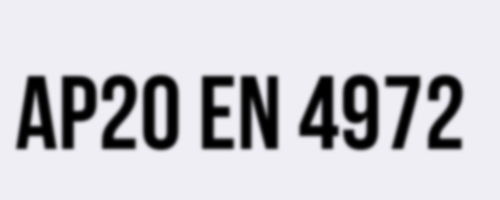

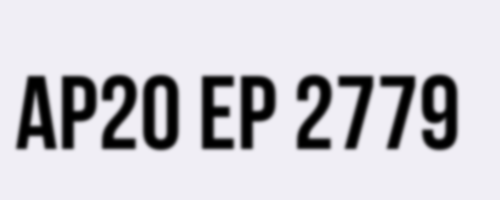

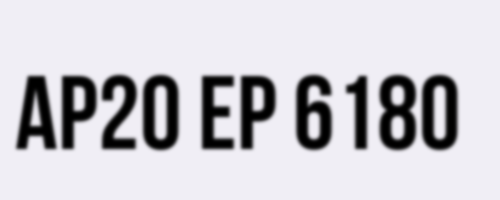

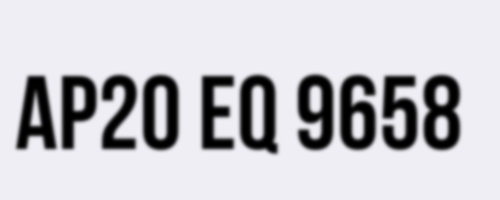

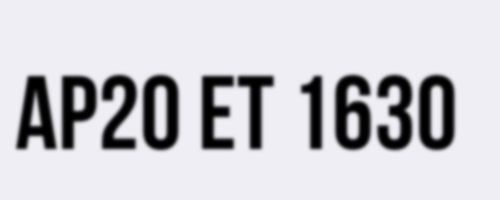

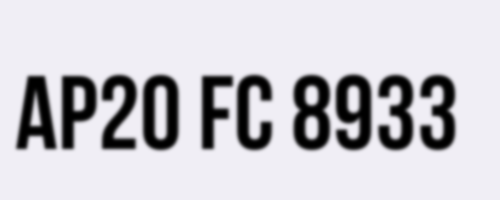

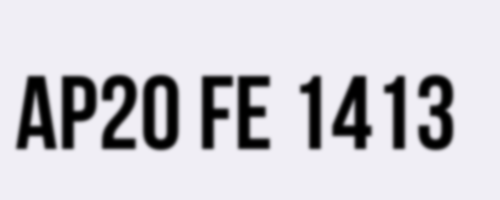

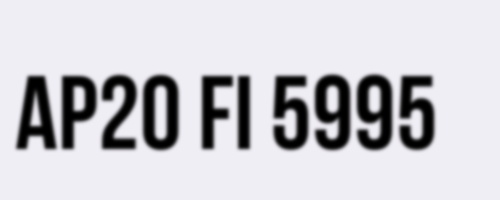

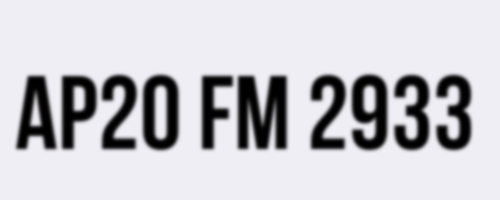

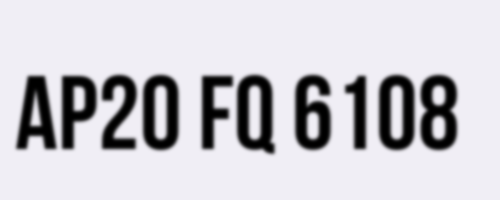

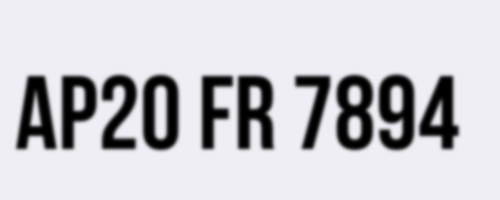

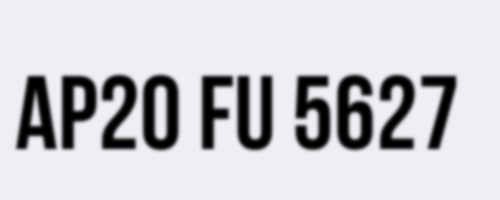

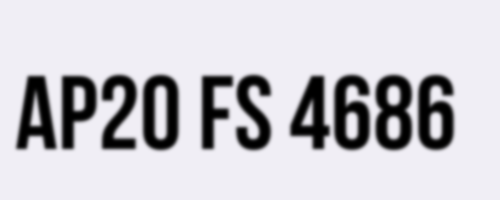

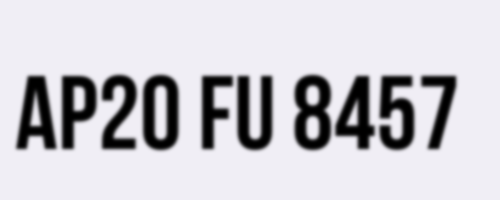

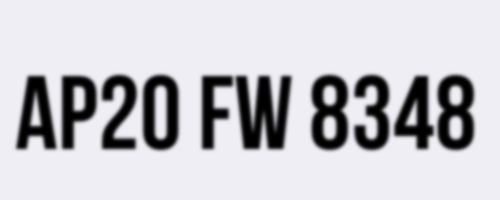

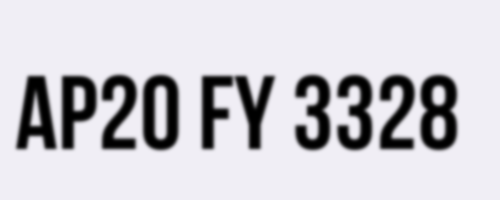

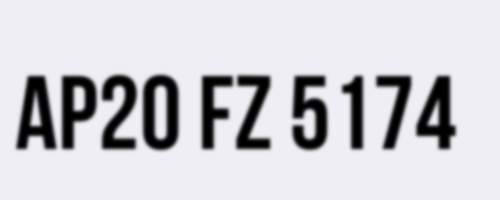

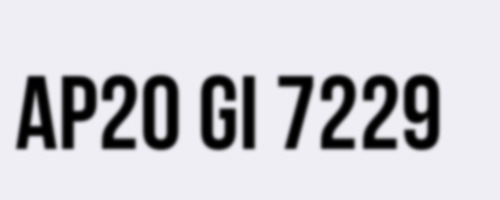

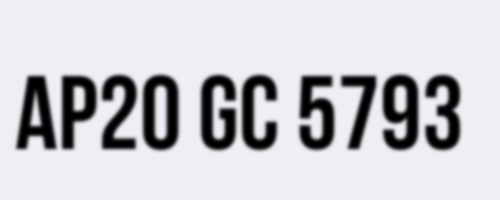

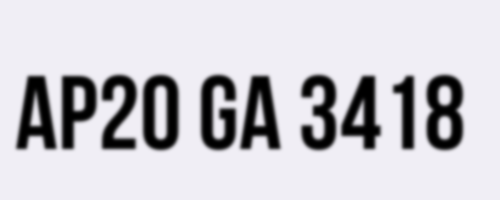

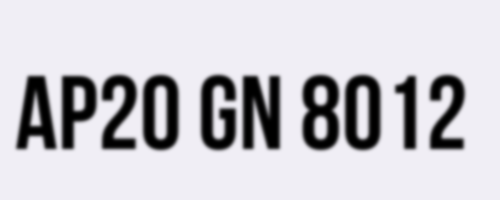

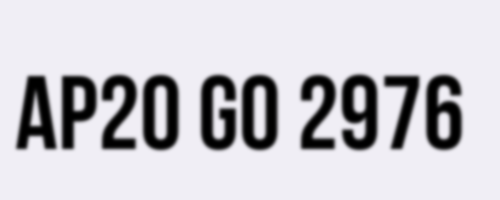

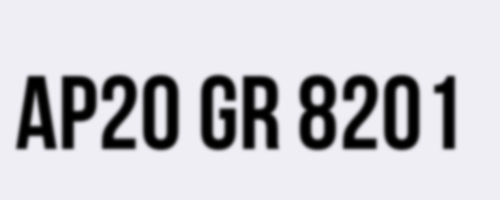

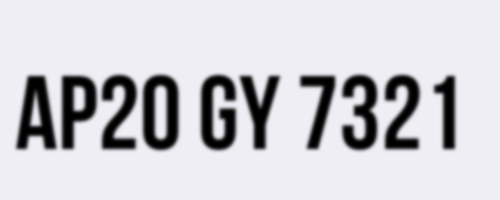

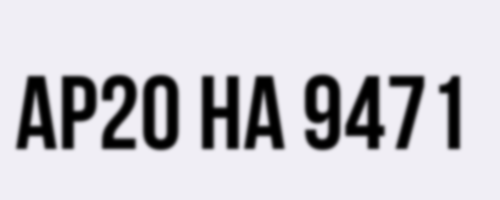

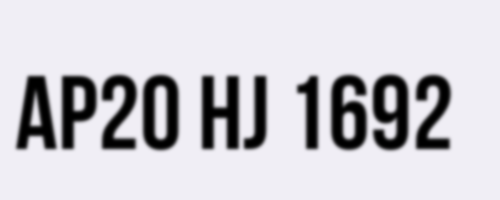

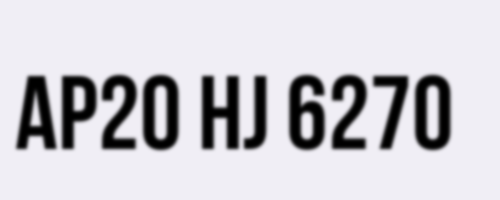

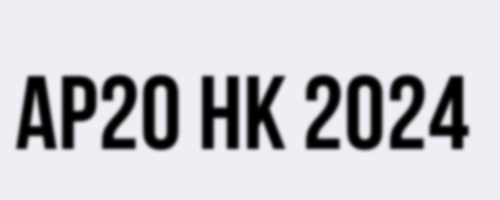

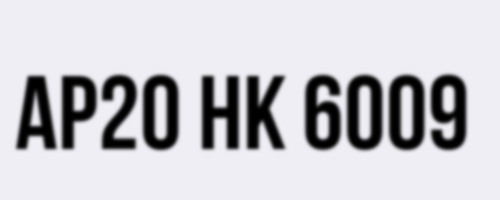

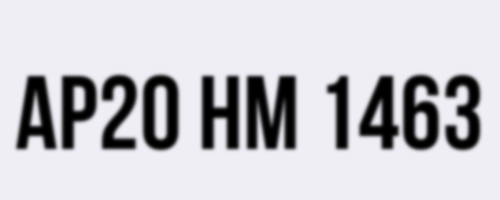

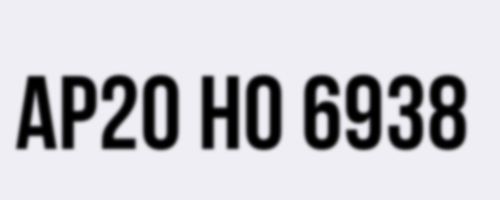

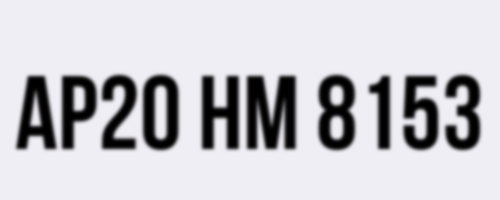

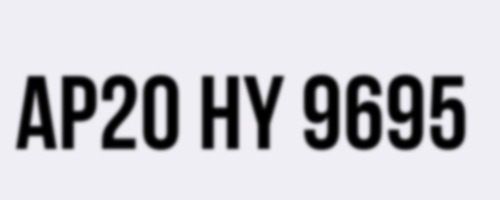

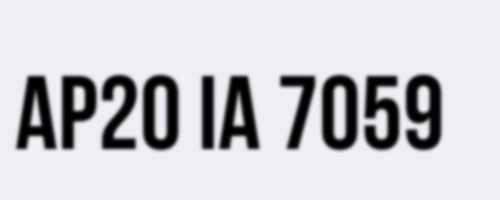

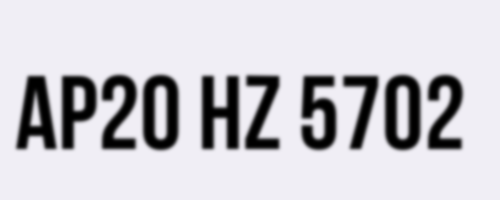

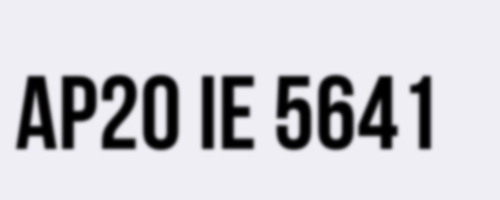

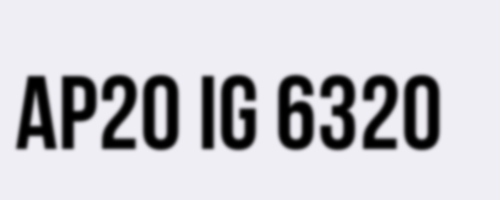

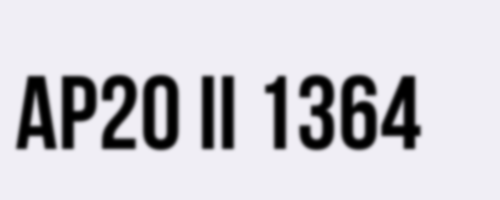

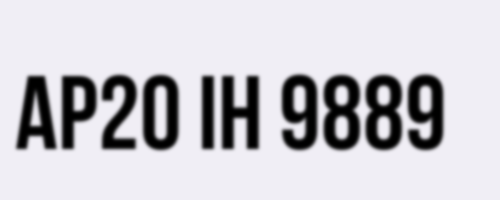

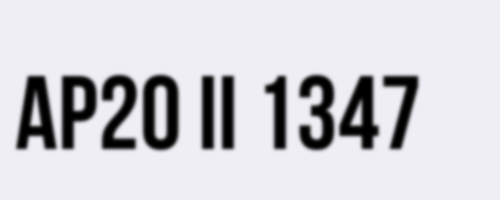

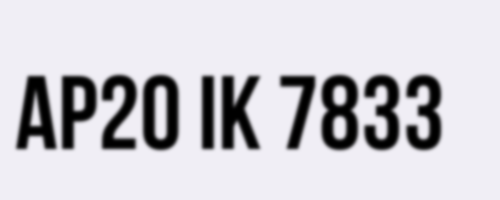

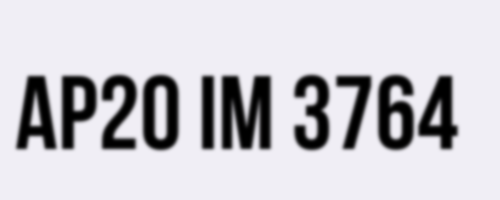

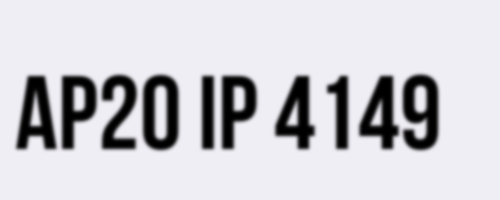

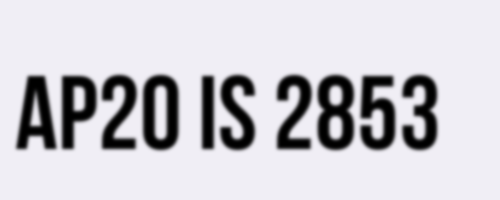

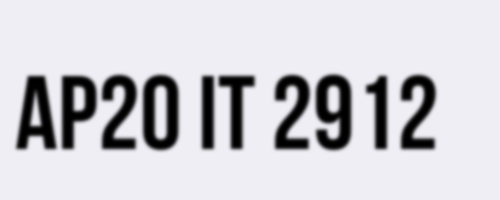

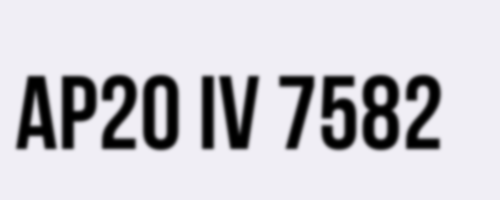

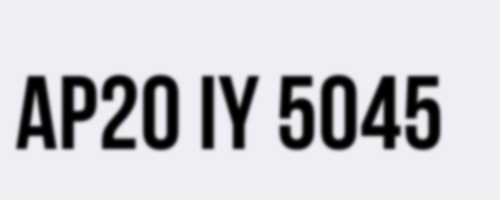

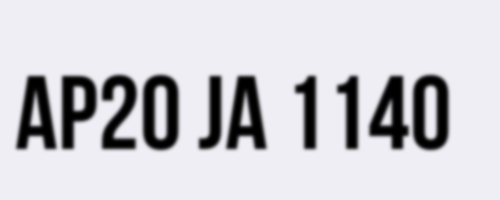

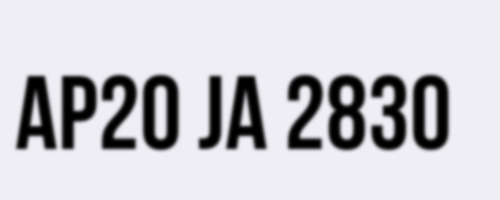

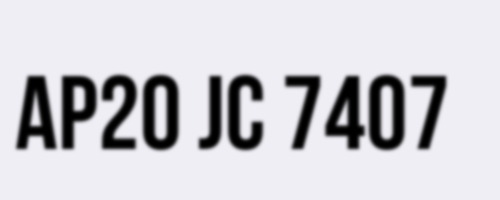

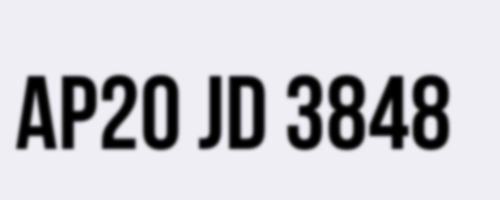

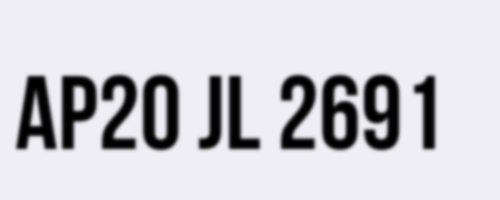

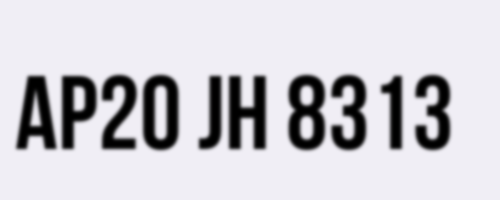

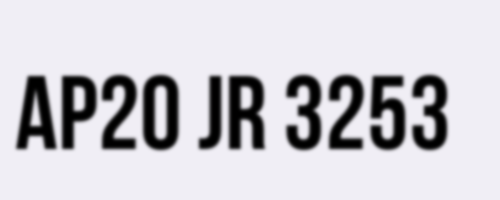

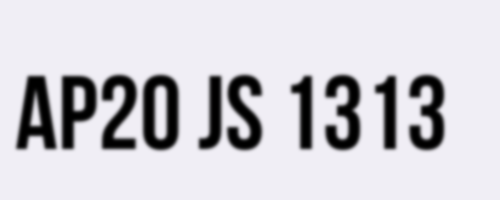

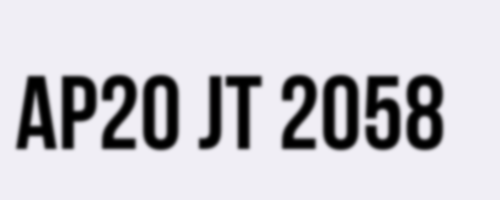

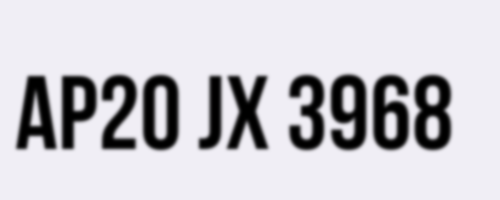

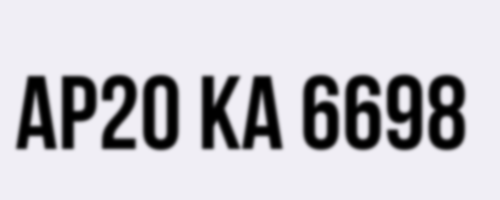

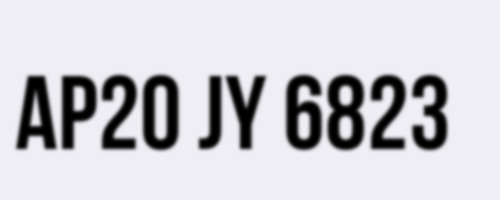

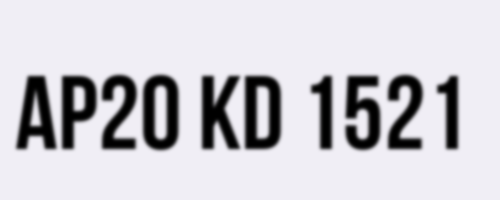

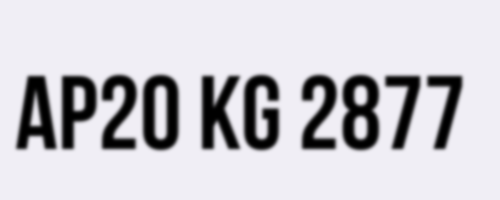

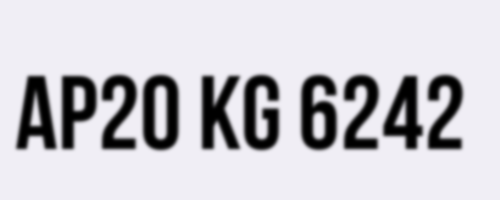

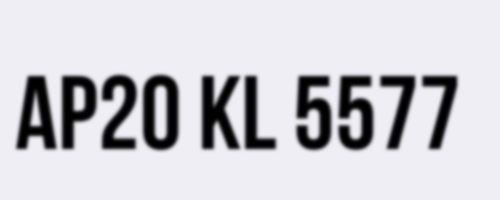

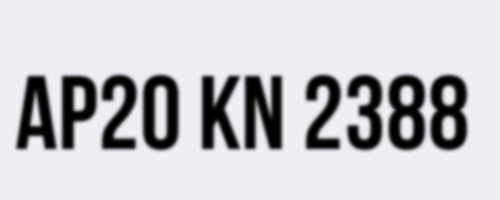

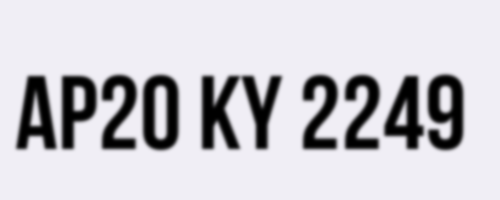

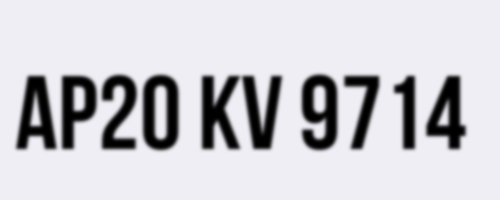

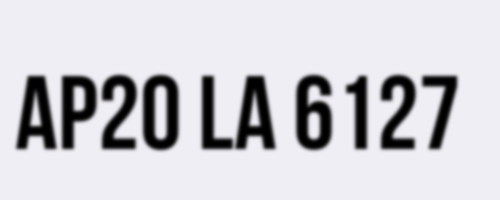

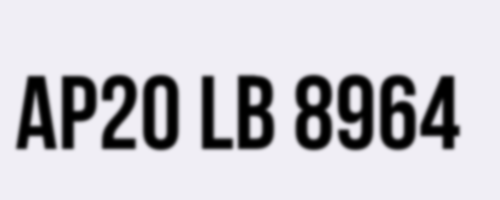

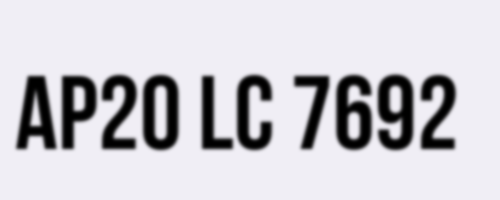

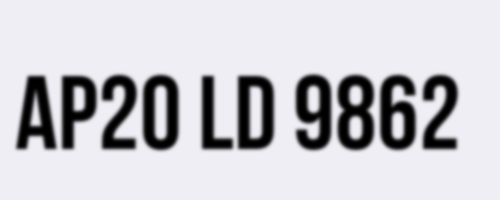

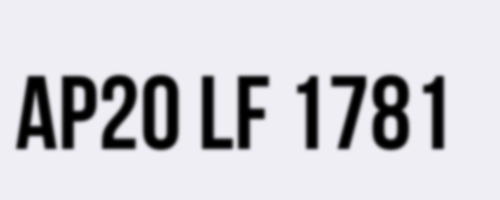

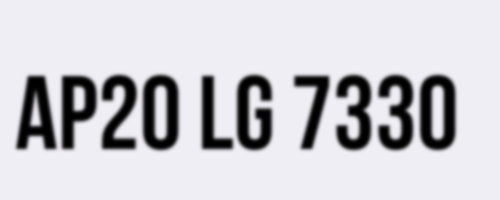

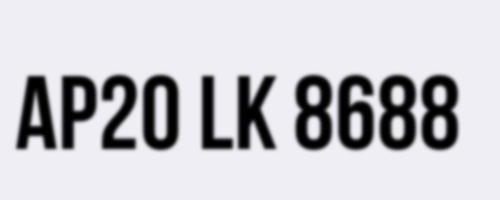

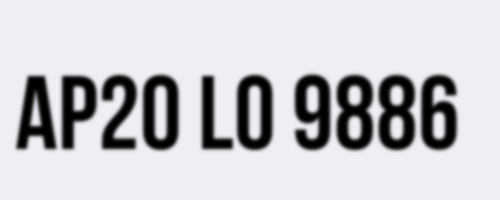

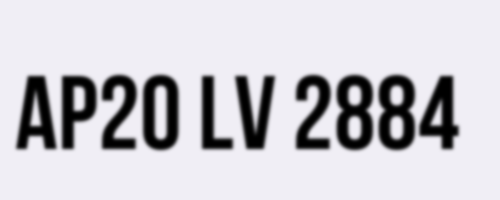

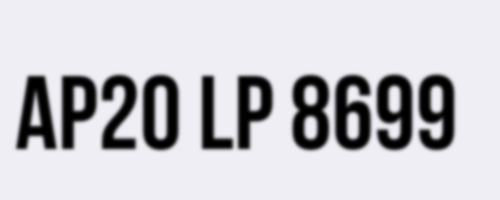

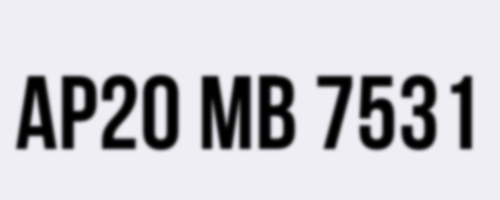

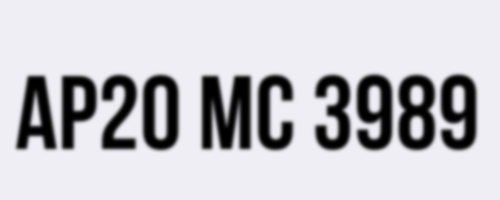

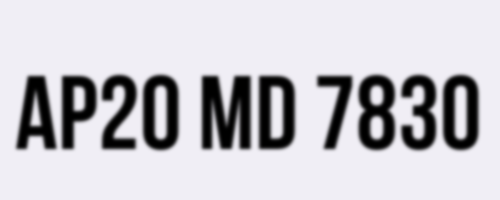

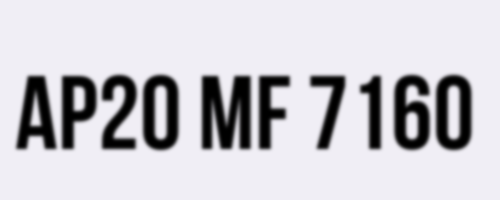

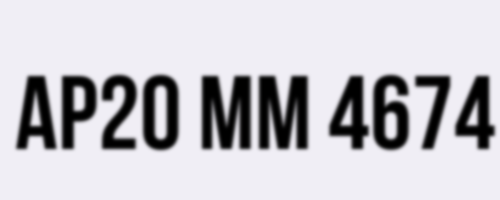

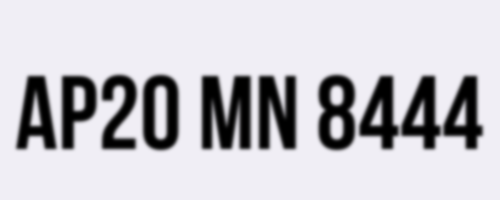

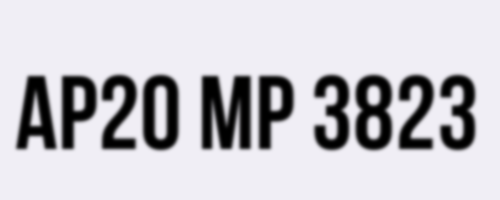

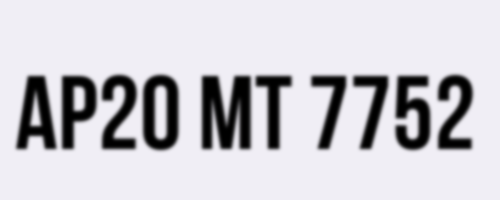

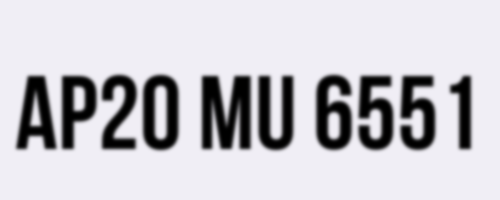

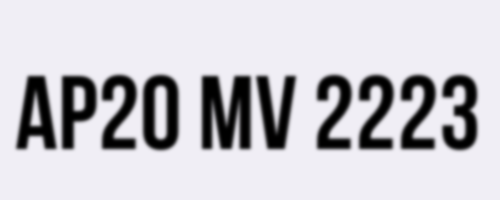

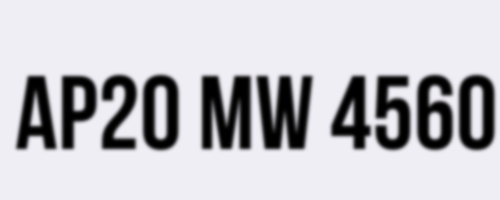

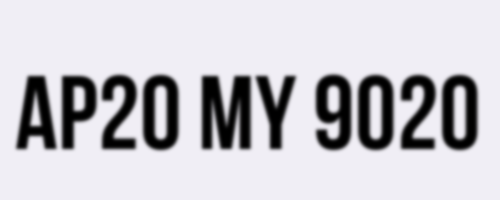

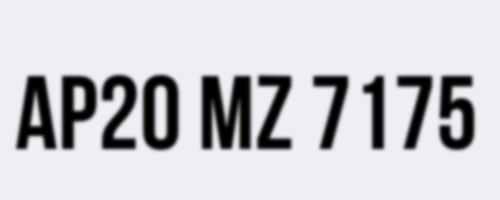

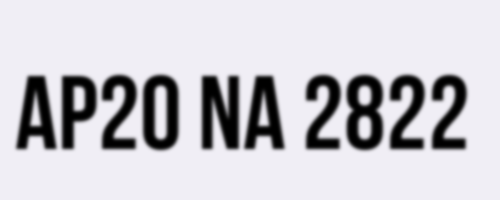

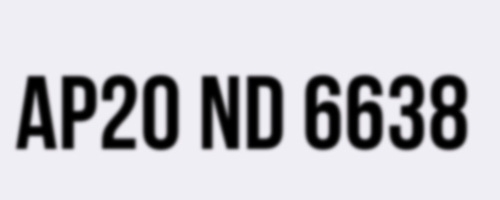

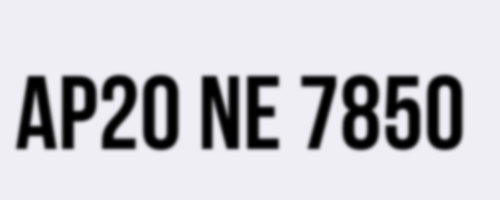

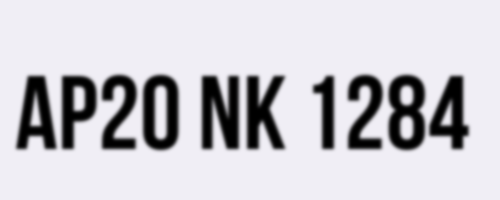

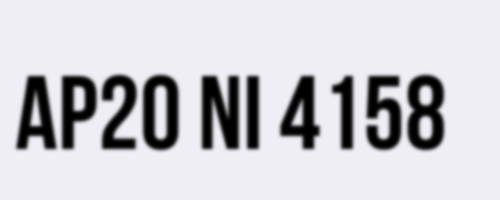

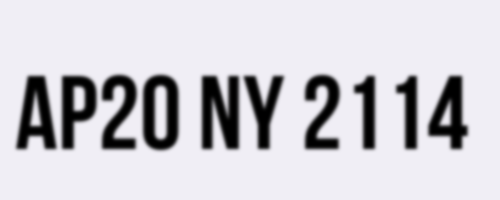

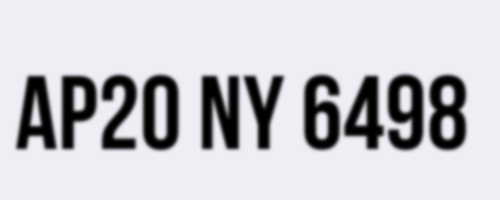

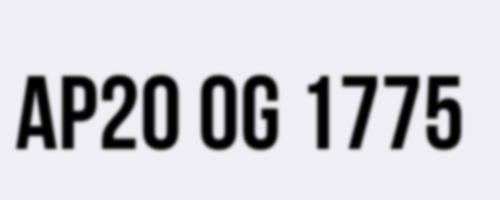

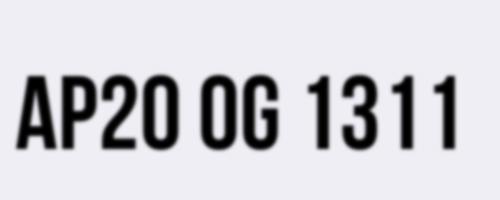

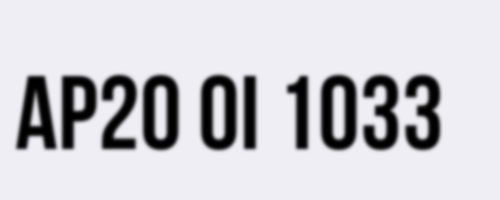

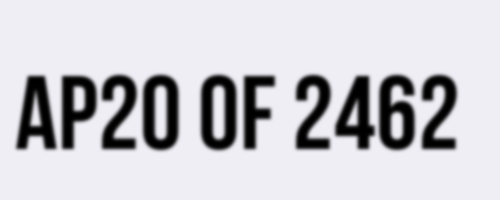

KeyboardInterrupt: ignored

In [ ]:
result=[]
label=[]
i=0
path='/content/drive/MyDrive/Forensics/license/license/synthetic_data/train1'
for filename in os.listdir(path):
  i+=1
  img = cv2.imread(os.path.join(path,filename))
  if img is not None:   
    img_np=np.array(img)
    s=9#+((i%7)*2)
    img=cv2.GaussianBlur(img_np,(s,s),0)
    char = segment_characters(img)
    cv2_imshow(img)
    # cv2_imshow(char)
    result.append(show_results(char))
    # cv2_imshow(char)
    #print(filename)
    label.append(filename.split('.')[0])
    # for i in range(10):
    #   plt.subplot(1, 10, i+1)
    #   plt.imshow(char[i], cmap='gray')
    #   plt.axis('off')
    # Segmented characters and their predicted value.
    # plt.figure(figsize=(10,6))
    # for i,ch in enumerate(char):
    #     img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    #     plt.subplot(3,4,i+1)
    #     plt.imshow(img,cmap='gray')
    #     plt.title(f'predicted: {show_results(char)[i]}')
    #     plt.axis('off')
    # plt.show()
    if i%1000 ==0:
      print(i)
    if i%5000==0:
      with open('/content/drive/MyDrive/Forensics/binaries/result_synthetic_4', 'wb') as fileobj:
        pickle.dump(result, fileobj)
      with open('/content/drive/MyDrive/Forensics/binaries/result_synthetic_4_label', 'wb') as fileobj:
        pickle.dump(label, fileobj)


In [ ]:
with open('/content/drive/MyDrive/Forensics/binaries/real_world_result_normal', 'wb') as fileobj:
  pickle.dump(result, fileobj)

In [ ]:
len(result)

1049

In [ ]:
dbfile = open('/content/drive/MyDrive/Forensics/binaries/real_world_label', 'rb')     
x_test_label = pickle.load(dbfile)
dbfile.close()

In [ ]:
len(x_test_label)

5121

In [ ]:
dbfile = open('/content/drive/MyDrive/Forensics/binaries/result_synthetic1', 'rb')     
result = pickle.load(dbfile)
dbfile.close()

In [ ]:
for i in range(len(result)):
  l=len(label[i])
  if l<10:
    ch='#'
    label[i]+=(10-l)*ch

In [ ]:
for i in range(len(result)):
  l=len(result[i])
  if l<10:
    ch='#'
    result[i]+=(10-l)*ch

In [ ]:
len(result)

1049

In [ ]:
c=np.zeros(10)
for i in range(len(result)):
  for j in range(10):
    if label[i][j]==result[i][j]:
      c[j]+=1
c=c/len(result)
c

array([0.8551001 , 0.93708294, 0.94375596, 0.86367969, 0.76835081,
       0.7521449 , 0.80743565, 0.83317445, 0.82459485, 0.85224023])

In [ ]:
#show the output : 
dbfile = open('/content/drive/MyDrive/Forensics/binaries/result_real_3', 'rb')


#Real World dataset

In [ ]:
image_list = []
file_names=[]
i=0
path='/content/drive/MyDrive/Forensics/in'
for filename in os.listdir(path):
    #print(filename.split('.')[0][-1])
    i+=1
    if i%1000==0:
      print(i)
    img = cv2.imread(os.path.join(path,filename))
    if img is not None and filename.split('.')[0][-1]!=')':
        #img_=cv2.resize(img,(200,60),interpolation = cv2.INTER_CUBIC)
        img_np=np.array(img)
        image_list.append(img_np)
        file_names.append(filename)

NameError: ignored

In [ ]:
x_test1=np.array(image_list)

In [ ]:
result=[]
for i in range(len(x_test1)):
  char = segment_characters(x_test[i])
  result.append(show_results(char))
  if i%1000 ==0:
    print(i)

In [ ]:
for i in range(len(file_names)):
  l=len(file_names[i])
  if l<10:
    ch='#'
    file_names[i]+=(10-l)*ch

In [ ]:
for i in range(len(result)):
  l=len(result[i])
  if l<10:
    ch='#'
    result[i]+=(10-l)*ch

In [ ]:
c=np.zeros(10)
for i in range(len(file_names)):
  for j in range(10):
    if file_names[i][j]==result[i][j]:
      c[j]+=1
c=c/len(file_names)
c

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

#DATA GENERATION

In [ ]:
import tensorflow as tf # for building CNN architecture and training model
from google.colab.patches import cv2_imshow # visualisation
from tensorflow.keras import Model, Sequential, callbacks # for building CNN architecture and training model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout # for building CNN architecture and training model
from tensorflow.keras.losses import SparseCategoricalCrossentropy # to define loss
from tensorflow.keras.optimizers import Adam # to define optimizer
from PIL import Image, ImageOps #Image operations
import numpy as np # matrix manupulation
import pickle # loading saved arrays of training, validation and testing images
import os # file and folder manupulation
import cv2 # open-cv
import re # regex
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
image_list = []
file_names=[]
i=0
path='/content/drive/MyDrive/Forensics/license/license/train/train'
for filename in os.listdir(path):
    #print(filename.split('.')[0][-1])
    i+=1
    if i%1000==0:
      print(i)
    img = cv2.imread(os.path.join(path,filename))
    if img is not None and filename.split('.')[0][-1]!=')':
        img_=cv2.resize(img,(200,60),interpolation = cv2.INTER_CUBIC)
        img_np=np.array(img_)
        image_list.append(cv2.GaussianBlur(img_np,(3,3),0))
        file_names.append(filename)

In [ ]:
with open('/content/drive/MyDrive/Forensics/binaries/train', 'wb') as fileobj:
  pickle.dump(image_list, fileobj)

In [ ]:
with open('/content/drive/MyDrive/Forensics/binaries/train_label', 'wb') as fileobj:
  pickle.dump(file_names, fileobj)

In [ ]:
len(x_train)

In [ ]:
len(x_train_label)

In [ ]:
x_train.extend(x_train1)
x_train_label.extend(x_train1_label)


In [ ]:
! pip install Augmentor

In [ ]:
import Augmentor
p = Augmentor.Pipeline("/content/drive/MyDrive/Forensics/license/license/train")

In [ ]:
p.skew_left_right(probability =1,magnitude=0.15)
p.sample(40750)

In [ ]:
p.random_brightness(probability=.5,min_factor=.5,max_factor=1.75)

#TEST


In [ ]:
def segment(image) :

    # Preprocess cropped license plate image 
    img_lp = cv2.resize(image, (333, 75),interpolation=cv2.INTER_AREA)
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/10,
                       LP_WIDTH,
                       LP_HEIGHT/20,
                       3*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    # print(dimensions)
    char_list = find(dimensions,img_binary_lp)

    return char_list

In [ ]:
def find(dimensions, img) :
    # gray_img = cv2.bilateralFilter(img, 11, 17, 17)
    # edged_img = cv2.Canny(gray_img, 30, 200) 
 
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(cntrs))
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
          x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

          char_copy = np.zeros((44,24))
          # extracting each character using the enclosing rectangle's coordinates.
          char = img[intY:intY+intHeight, intX:intX+intWidth]
          char = cv2.resize(char, (20, 40))
          
          cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
          plt.imshow(ii, cmap='gray')

          # Make result formatted for classification: invert colors
          char = cv2.subtract(255, char)

          # Resize the image to 24x44 with black border
          char_copy[2:42, 2:22] = char
          char_copy[0:2, :] = 0
          char_copy[:, 0:2] = 0
          char_copy[42:44, :] = 0
          char_copy[:, 22:24] = 0

          img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
imgr=cv2.imread("/content/drive/MyDrive/Forensics/in/MH02BM3295.png")

In [ ]:
cv2_imshow(imgr)

In [ ]:
ch=segment(imgr)

#Ignore

In [ ]:
import cv2 # Computer vision library
 
# Read the color image
 
# Make a copy
new_image = imgr.copy()
 
# Convert the image to grayscale
gray = cv2.cvtColor(imgr, cv2.COLOR_BGR2GRAY)
 
# Display the grayscale image
cv2.imshow('Gray image', gray)  
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows
 
# Convert the grayscale image to binary
ret, binary = cv2.threshold(gray, 100, 255, 
  cv2.THRESH_OTSU)
 
# Display the binary image
cv2_imshow('Binary image', binary)
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows
 
# To detect object contours, we want a black background and a white 
# foreground, so we invert the image (i.e. 255 - pixel value)
inverted_binary = ~binary
cv2_imshow('Inverted binary image', inverted_binary)
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows
 
# Find the contours on the inverted binary image, and store them in a list
# Contours are drawn around white blobs.
# hierarchy variable contains info on the relationship between the contours
contours, hierarchy = cv2.findContours(inverted_binary,
  cv2.RETR_TREE,
  cv2.CHAIN_APPROX_SIMPLE)
     
# Draw the contours (in red) on the original image and display the result
# Input color code is in BGR (blue, green, red) format
# -1 means to draw all contours
with_contours = cv2.drawContours(imgr, contours, -1,(255,0,255),3)
cv2_imshow('Detected contours', with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# Show the total number of contours that were detected
print('Total number of contours detected: ' + str(len(contours)))
 
# Draw just the first contour
# The 0 means to draw the first contour
first_contour = cv2.drawContours(new_image, contours, 0,(255,0,255),3)
cv2_imshow('First detected contour', first_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# Draw a bounding box around the first contour
# x is the starting x coordinate of the bounding box
# y is the starting y coordinate of the bounding box
# w is the width of the bounding box
# h is the height of the bounding box
x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(first_contour,(x,y), (x+w,y+h), (255,0,0), 5)
cv2_imshow('First contour with bounding box', first_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# Draw a bounding box around all contours
for c in contours:
  x, y, w, h = cv2.boundingRect(c)
 
    # Make sure contour area is large enough
  if (cv2.contourArea(c)) > 10:
    cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)
         
cv2_imshow('All contours with bounding box', with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
ch=segment(imgr)

#Result

In [ ]:
dbfile = open('/content/drive/MyDrive/Forensics/binaries/result_synthetic1', 'rb')     
result = pickle.load(dbfile)
dbfile.close()

In [ ]:
len(result)

15000

In [ ]:
result=[]
label=[]
i=0
path='/content/drive/MyDrive/Forensics/license/license/synthetic_data/train1'
for filename in os.listdir(path):
  i+=1
  #img = cv2.imread(os.path.join(path,filename))
  #if img is not None and filename.split('.')[0][-1]!=')':   
    #img_np=np.array(img)
    #s=13#+((i%7)*2)
    #img=cv2.GaussianBlur(img_np,(s,s),0)
    #char = segment_characters(img)
    #result.append(show_results(char))
    #print(filename)
  label.append(filename.split('.')[0])
    # for i in range(10):
    #   plt.subplot(1, 10, i+1)
    #   plt.imshow(char[i], cmap='gray')
    #   plt.axis('off')
    # Segmented characters and their predicted value.
    # plt.figure(figsize=(10,6))
    # for i,ch in enumerate(char):
    #     img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    #     plt.subplot(3,4,i+1)
    #     plt.imshow(img,cmap='gray')
    #     plt.title(f'predicted: {show_results(char)[i]}')
    #     plt.axis('off')
    # plt.show()
    # if i%1000 ==0:
    #   print(i)
    # if i%5000==0:
    #   with open('/content/drive/MyDrive/Forensics/binaries/result_synthetic_2', 'wb') as fileobj:
    #     pickle.dump(result, fileobj)


In [ ]:
for i in range(len(result)):
  l=len(label[i])
  if l<10:
    ch='#'
    label[i]+=(10-l)*ch

In [ ]:
for i in range(len(result)):
  l=len(result[i])
  if l<10:
    ch='#'
    result[i]+=(10-l)*ch

In [ ]:
len(result)

15000

In [ ]:
for i in range(len(result)):
  print(result[i],label[i])

In [ ]:
c=np.zeros(10)
for i in range(len(result)):
  for j in range(10):
    if label[i][j]==result[i][j]:
      c[j]+=1
c=c/len(result)

In [ ]:
c

array([0.96666667, 0.98333333, 1.        , 0.92766667, 0.8062    ,
       0.87733333, 0.82246667, 0.8378    , 0.83853333, 0.8312    ])